# Training a simple linear classification NN with manual pytorch autograd

In [317]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pandas import read_csv
import numpy as np

In [318]:
def plot_points(X, y):
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'blue', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'red', edgecolor = 'k')

def display(m, b, color='g--'):
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    x = np.arange(-10, 10, 0.1)
    plt.plot(x, m*x+b, color)

In [319]:
data = read_csv('data.csv', header=None, names=['x','y','target'])
data.head()

,x,y,target
0,0.78051,-0.063669,1
1,0.28774,0.291390,1
2,0.40714,0.178780,1
3,0.29230,0.421700,1
4,0.50922,0.352560,1


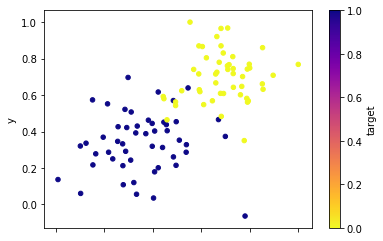

In [320]:
data.plot(kind='scatter', x='x', y='y', c = 'target', colormap = 'plasma_r')
plt.show()

In [321]:
class PointsDataset(Dataset):
    def __init__(self, data, transform = None):
        self.points = torch.as_tensor(data[:,:2], dtype=torch.float) # coordinates x and y
        self.labels = torch.as_tensor(data[:,2], dtype=torch.float) # lablels
        self.len = len(data)
        
    def __getitem__(self, index):
        return self.points[index], self.labels[index]
    def __len__(self):
        return self.len

In [322]:
points = PointsDataset(data.values)

In [323]:
points_loader = DataLoader(points, batch_size=20, shuffle=True)

In [325]:
# display the minibatch data 
iter(points_loader).next()[0]

tensor([[0.6905, 0.8306],
        [0.5915, 0.6293],
        [0.7771, 0.3503],
        [0.6791, 0.6092],
        [0.3215, 0.1201],
        [0.6597, 0.6667],
        [0.8518, 0.6612],
        [0.2548, 0.3460],
        [0.5899, 0.8695],
        [0.6642, 0.7252],
        [0.5453, 0.6391],
        [0.6991, 0.3731],
        [0.2564, 0.4262],
        [0.3085, 0.2431],
        [0.7144, 0.7668],
        [0.5374, 0.2864],
        [0.4591, 0.4043],
        [0.6097, 0.5476],
        [0.4400, 0.3124],
        [0.2130, 0.5517]])

In [327]:
class PointsNN(nn.Module):
    """
    logistic regression via one layer neural network
    gives out probability of positive class
    """
    def __init__(self):
        super(PointsNN, self).__init__()
        self.l1 = nn.Linear(2,1)
    def forward(self, x):
        x = self.l1(x)
        score = F.relu(x)
        out = torch.sigmoid(x)
        return out.squeeze() 

In [328]:
points_nn = PointsNN()

In [329]:
points_nn(iter(points_loader).next()[0])

tensor([0.4180, 0.4071, 0.4841, 0.4123, 0.3916, 0.4393, 0.4028, 0.4763, 0.4357,
        0.4117, 0.4725, 0.4429, 0.4495, 0.4803, 0.4193, 0.4787, 0.4235, 0.4350,
        0.4957, 0.4184], grad_fn=<SqueezeBackward0>)

In [330]:
def get_weights(net):
    """
    get y = m*x + b coefficients from the network
    """
    w1, w2 = net.l1.weight.data.numpy()[0]
    b = net.l1.bias.item()
    return -w1/w2, -b/w2

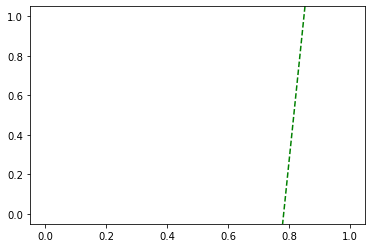

In [331]:
m, b = get_weights(points_nn)
display(m,b)

## Single step

In [338]:
lr = 0.1
criterion = nn.BCELoss()

In [339]:
points_batch, labels_batch = iter(points_loader).next()
points_batch, labels_batch

(tensor([[0.3710, 0.3881],
         [0.1242, 0.3359],
         [0.7876, 0.5818],
         [0.4938, 0.5423],
         [0.6209, 0.8042],
         [0.7076, 0.7602],
         [0.3295, 0.3922],
         [0.7669, 0.6474],
         [0.6791, 0.6092],
         [0.6813, 0.8698],
         [0.6824, 0.4830],
         [0.5453, 0.6391],
         [0.5942, 0.6186],
         [0.5374, 0.2864],
         [0.2849, 0.5214],
         [0.6097, 0.5476],
         [0.8518, 0.6612],
         [0.3356, 0.4298],
         [0.4071, 0.1788],
         [0.3971, 0.4444]]),
 tensor([1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
         1., 1.]))

In [340]:
out = points_nn(points_batch)
out

tensor([0.4301, 0.3922, 0.4945, 0.4479, 0.4654, 0.4798, 0.4235, 0.4905, 0.4768,
        0.4744, 0.4787, 0.4551, 0.4631, 0.4576, 0.4152, 0.4664, 0.5040, 0.4241,
        0.4380, 0.4336], grad_fn=<SqueezeBackward0>)

In [341]:
loss = criterion(out, labels_batch)
loss

tensor(0.7365, grad_fn=<BinaryCrossEntropyBackward>)

In [342]:
loss.backward()

In [343]:
points_nn.l1.weight.grad, points_nn.l1.bias.grad

(tensor([[0.1118, 0.1293]]), tensor([-0.0405]))

In [344]:
with torch.no_grad():
    # update weights and biases
    points_nn.l1.weight.data -= lr*points_nn.l1.weight.grad
    # update the bias
    points_nn.l1.bias.data -= lr*points_nn.l1.bias.grad
    
    points_nn.l1.weight.grad.zero_()
    points_nn.l1.bias.grad.zero_()

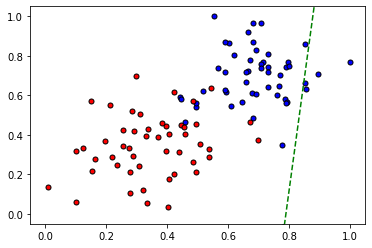

In [345]:
m, b = get_weights(points_nn)
display(m,b)
plot_points(data.iloc[:,:2].values, data.iloc[:,2].values)
plt.show()

## Main training loop

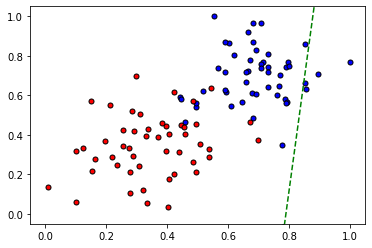

In [346]:
# reset the weights
#points_nn.l1.weight.data = torch.FloatTensor([[1,-1]])
#points_nn.l1.bias.data = torch.FloatTensor([0])
# display the picture visually
m, b = get_weights(points_nn)
display(m,b)
plot_points(data.iloc[:,:2].values, data.iloc[:,2].values)
plt.show()

In [347]:
# number of batches in a loader, and points in one epoch/dataset
len(points_loader), len(points), len(points_loader.dataset)

(5, 100, 100)

In [348]:
# learning rate
lr = 0.1

# loss function
criterion = nn.BCELoss()

# number of epochs
NEPOCH = 1000

# weights and biases to draw decision line - will use it later to draw how it moves with every minibatch applied
weights_and_biases = []

# counter of minibatches
minibatch_counter = 0

# give output every X mini-batches
log_interval = 10

In [349]:
for epoch in range(NEPOCH):   
    # error on epoch
    error = 0
    for points_batch, labels_batch in points_loader:
        #set_trace()
        # zero grad the parameters
        points_nn.l1.weight.grad.zero_()
        points_nn.l1.bias.grad.zero_()
        
        # calculate the output of the network
        out = points_nn(points_batch)
        
        # calculate the loss
        loss = criterion(out, labels_batch)
        
        # accumelate the error for the epoch
        error += loss.item()
        
        # backprop grads from the loss to the weights
        loss.backward()
        
        # update the weights
        with torch.no_grad():
            points_nn.l1.weight.data -= lr*points_nn.l1.weight.grad
            points_nn.l1.bias.data -= lr*points_nn.l1.bias.grad
        
        minibatch_counter += 1
        
        if minibatch_counter%log_interval == 0:
            print(f'Epoch {epoch} of {len(points_loader)*len(points_loader.dataset)}: error={error:.3f}') 
            weights_and_biases.append(get_weights(points_nn))

Epoch 1 of 500: error=3.711
Epoch 3 of 500: error=3.649
Epoch 5 of 500: error=3.597
Epoch 7 of 500: error=3.545
Epoch 9 of 500: error=3.501
Epoch 11 of 500: error=3.452
Epoch 13 of 500: error=3.407
Epoch 15 of 500: error=3.358
Epoch 17 of 500: error=3.314
Epoch 19 of 500: error=3.272
Epoch 21 of 500: error=3.238
Epoch 23 of 500: error=3.190
Epoch 25 of 500: error=3.152
Epoch 27 of 500: error=3.115
Epoch 29 of 500: error=3.074
Epoch 31 of 500: error=3.038
Epoch 33 of 500: error=3.002
Epoch 35 of 500: error=2.967
Epoch 37 of 500: error=2.932
Epoch 39 of 500: error=2.900
Epoch 41 of 500: error=2.868
Epoch 43 of 500: error=2.835
Epoch 45 of 500: error=2.804
Epoch 47 of 500: error=2.775
Epoch 49 of 500: error=2.748
Epoch 51 of 500: error=2.717
Epoch 53 of 500: error=2.692
Epoch 55 of 500: error=2.664
Epoch 57 of 500: error=2.634
Epoch 59 of 500: error=2.608
Epoch 61 of 500: error=2.588
Epoch 63 of 500: error=2.559
Epoch 65 of 500: error=2.534
Epoch 67 of 500: error=2.511
Epoch 69 of 500: er

In [350]:
len(weights_and_biases)

500

### Dislpay how border line is moving with every log_ingeral's iteration over minibatches

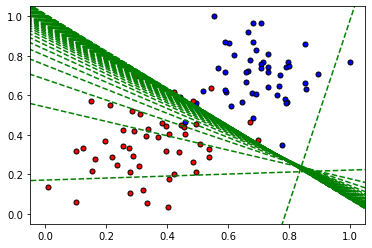

In [352]:
for i , (m,b) in enumerate(weights_and_biases):
    if i%log_interval == 0:
        display(m,b)
plot_points(data.iloc[:,:2].values, data.iloc[:,2].values)
plt.show()

In [353]:
points_nn.l1.weight.data, points_nn.l1.bias.data

(tensor([[-6.9959, -7.4718]]), tensor([7.5483]))